---
title: Minimum variance analysis (MVA)
---

Notes:

- To ensure the accuracy of MVA, only when the ratio of the middle to the minimum eigenvalue (labeled QMVA for simplicity) is larger than 3 are the results used for further analysis.


In [ ]:
# | default_exp propeties/mva
# | export
import xarray as xr
import numpy as np

from lmfit.models import StepModel, ConstantModel
from lmfit import Parameters

from typing import Literal

The following method implicitly assumes the data is evenly sampled, otherwise, data resampling is needed.


In [ ]:
# | exports
def minvar(data: np.ndarray):
    """
    see `pyspedas.cotrans.minvar`

    This program computes the principal variance directions and variances of a
    vector quantity as well as the associated eigenvalues.

    Parameters
    -----------
    data:
        Vxyz, an (npoints, ndim) array of data(ie Nx3)

    Returns
    -------
    vrot:
        an array of (npoints, ndim) containing the rotated data in the new coordinate system, ijk.
        Vi(maximum direction)=vrot[0,:]
        Vj(intermediate direction)=vrot[1,:]
        Vk(minimum variance direction)=Vrot[2,:]
    v:
        an (ndim,ndim) array containing the principal axes vectors
        Maximum variance direction eigenvector, Vi=v[*,0]
        Intermediate variance direction, Vj=v[*,1] (descending order)
    w:
        the eigenvalues of the computation
    """

    #  Min var starts here
    # data must be Nx3
    vecavg = np.nanmean(np.nan_to_num(data, nan=0.0), axis=0)

    mvamat = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            mvamat[i, j] = (
                np.nanmean(np.nan_to_num(data[:, i] * data[:, j], nan=0.0))
                - vecavg[i] * vecavg[j]
            )

    # Calculate eigenvalues and eigenvectors
    w, v = np.linalg.eigh(mvamat, UPLO="U")

    # Sorting to ensure descending order
    w = np.abs(w)
    idx = np.flip(np.argsort(w))

    # IDL compatability
    if True:
        if np.sum(w) == 0.0:
            idx = [0, 2, 1]

    w = w[idx]
    v = v[:, idx]

    # Rotate intermediate var direction if system is not Right Handed
    YcrossZdotX = v[0, 0] * (v[1, 1] * v[2, 2] - v[2, 1] * v[1, 2])
    if YcrossZdotX < 0:
        v[:, 1] = -v[:, 1]
        # v[:, 2] = -v[:, 2] # Should not it is being flipped at Z-axis?

    # Ensure minvar direction is along +Z (for FAC system)
    if v[2, 2] < 0:
        v[:, 2] = -v[:, 2]
        v[:, 1] = -v[:, 1]

    vrot = np.array([np.dot(row, v) for row in data])

    return vrot, v, w

## MVA related features


In [ ]:
# | export
def calc_mva_features(data: np.ndarray):
    """
    Compute MVA features based on the given data array.

    Parameters:
    - data (np.ndarray): Input data

    Returns:
    - List: Computed features
    """

    # Compute variance properties
    vrot, v, _ = minvar(data)

    # Unit vector in the direction of the maxium, medium, minium variance magnetic field
    e_max = v[:, 0]
    e_min = v[:, 2]

    vec_mag = np.linalg.norm(vrot, axis=1)

    # Compute changes in each component of B_rot
    dvec = vrot[0] - vrot[-1]

    # Compute mean values
    vec_mag_mean = np.mean(vec_mag)
    vec_n_mean = np.mean(vrot[:, 2])
    VnOverVmag = vec_n_mean / vec_mag_mean

    # Compute relative changes in magnitude
    dvec_mag = vec_mag[-1] - vec_mag[0]
    dBOverB = np.abs(dvec_mag / vec_mag_mean)
    dBOverB_max = (np.max(vec_mag) - np.min(vec_mag)) / vec_mag_mean

    result = {
        "e_max": e_max,
        "e_min": e_min,
        "b_mag": vec_mag_mean,
        "b_n": vec_n_mean,
        "B.vec.before": vrot[0],
        "B.vec.after": vrot[-1],
        "B.before": vec_mag[0],
        "B.after": vec_mag[-1],
        "db_mag": dvec_mag,
        "bn_over_b": VnOverVmag,
        "db_over_b": dBOverB,
        "db_over_b_max": dBOverB_max,
        "dB_lmn": dvec,
    }
    return result, vrot

In [ ]:
# | export
def calc_maxiumum_variance_direction(data: xr.DataArray, datetime_unit="s", **kwargs):
    d_data = data.differentiate("time", datetime_unit=datetime_unit)
    return {"d_star": abs(d_data).max(dim="time").item()}

## Fit maximum variance direction


$$
f(x; A, \mu, \sigma, {\mathrm{form={}'logistic{}'}}) = A \left[1 - \frac{1}{1 + e^{\alpha}} \right]
$$

where $\alpha = (x - \mu)/{\sigma}$. And the derivative is

$$
\frac{df}{dx} = \frac{A}{\sigma} \frac{e^{\alpha}}{(1 + e^{\alpha})^2}
$$

at center $x = \mu$, the derivative is

$$
\frac{df}{dx} = \frac{A}{4 \sigma}
$$


In [ ]:
# | export
def fit_maxiumum_variance_direction(
    data: xr.DataArray, datetime_unit="s", return_best_fit: bool = False, **kwargs
):
    """
    Fit maximum variance direction data by model

    Note:
        - see `datetime_to_numeric` in `xarray.core.duck_array_ops` for more details about converting datetime to numeric
        - Xarray uses the numpy dtypes datetime64[ns] and timedelta64[ns] to represent datetime data.
    """
    time = data["time"].values
    x = (time - min(time)) / np.timedelta64(1, datetime_unit)
    y = data.values

    x_min, x_max = min(x), max(x)
    x_width = x_max - x_min

    # Create a model
    step_mod = StepModel(form="logistic")
    const_mod = ConstantModel()
    mod = step_mod + const_mod

    # Create parameters
    params = Parameters()

    init_amplitude = y[-1] - y[0]

    params.add(
        "center",
        value=(x_max + x_min) / 2.0,
        # min=x_min + x_width / 7.0,
        # max=x_max - x_width / 7.0,
    )
    params.add(
        "amplitude",
        value=init_amplitude,
        max=abs(init_amplitude) * 2.0,
        min=-abs(init_amplitude) * 2.0,
    )
    params.add("sigma", value=x_width / 7.0, min=0)

    if True:
        int_center_y = (y[-1] + y[0]) / 2.0
        c1 = 1 / 8
        params.add(
            "center_y",
            min=int_center_y - c1 * np.abs(init_amplitude),
            max=int_center_y + c1 * np.abs(init_amplitude),
        )
        params.add("c", expr="center_y - amplitude / 2.0")

    # Ensure there are enough data points to fit the model
    if len(y) < 4:
        # Not enough data points, return None or an empty result instead of raising an error
        amplitude = sigma = center = rsquared = chisqr = c = best_fit = np.nan
    else:
        out = mod.fit(y, params, x=x)
        amplitude = out.params["amplitude"].value
        sigma = out.params["sigma"].value
        center = out.params["center"].value
        c = out.params["c"].value
        rsquared = out.rsquared
        chisqr = out.chisqr
        best_fit = out.best_fit

    max_df = amplitude / (4 * sigma)

    d_time = min(time) + center * np.timedelta64(1, datetime_unit).astype(
        "timedelta64[ns]"
    )

    result = {
        "fit.vars.amplitude": amplitude,
        "fit.vars.sigma": sigma,
        "t.d_time": d_time,
        "d_star": max_df,
        "fit.vars.c": c,
        "fit.stat.rsquared": rsquared,
        "fit.stat.chisqr": chisqr,
    }
    if return_best_fit:
        result["fit.best_fit"] = best_fit
        result["fit.time"] = time
    return result

In [ ]:
# | export
def calc_mva_features_all(
    data: xr.DataArray, method=Literal["fit", "derivative"], **kwargs
):
    mva_features, vrot = calc_mva_features(data.to_numpy())
    data_l = xr.DataArray(vrot[:, 0], dims=["time"], coords={"time": data.time})

    if method == "fit":
        result = fit_maxiumum_variance_direction(data_l, **kwargs)
    elif method == "derivative":
        result = calc_maxiumum_variance_direction(data_l, **kwargs)
    return result | mva_features

## Fit Examples and Caveats

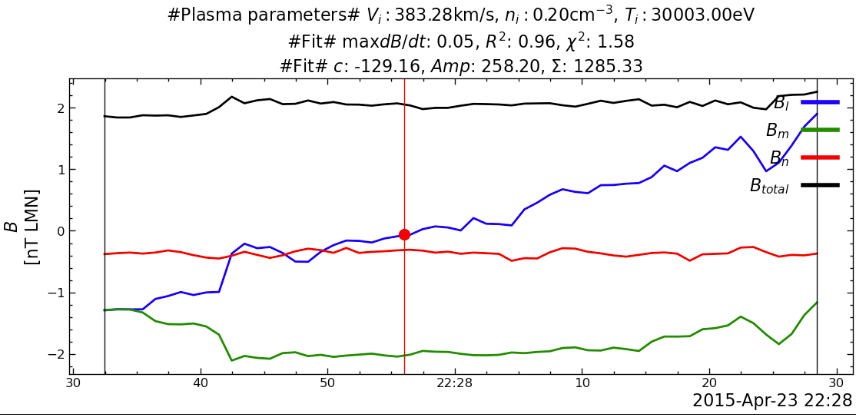

## Test


In [ ]:
# | code-summary: test for ts_max_distance function
import pandas as pd

time = pd.date_range("2000-01-01", periods=10)
x = np.linspace(0, np.pi, 10)
# generate data circular in three dimensions, so the biggest distance is between the first and the last point
data = np.zeros((10, 3))
data[:, 0] = np.cos(x)
data[:, 1] = np.sin(x)
data = xr.DataArray(data, coords={"time": time}, dims=["time", "space"])
fit_maxiumum_variance_direction(data[:, 0], return_best_fit=True)["fit.best_fit"]

array([ 1.01473047,  0.91997617,  0.75951811,  0.51243958,  0.18263172,
       -0.18270987, -0.51251774, -0.75959627, -0.92005434, -1.01480865])

In [ ]:
mva_features, vrot = calc_mva_features(data)
vrot.shape

(10, 3)

In [ ]:
# | eval: false
from fastcore.test import test_eq

# Generate synthetic data
np.random.seed(42)  # for reproducibility
data = np.random.rand(100, 3)  # 100 time points, 3-dimensional data
# Call the mva_features function
features, vrot = calc_mva_features(data)
_features = [
    0.3631060892452051,
    0.8978455426527485,
    -0.24905290500542857,
    0.09753158579102299,
    0.086943767300213,
    0.07393142040422575,
    1.1760056390752571,
    0.9609421690770317,
    0.6152039820297959,
    -0.5922397773398479,
    0.6402091632847049,
    0.61631157045453,
    1.2956351134759623,
    0.19091785005728523,
    0.5182488424049534,
    0.4957624347593598,
]
test_eq(features, _features)